## 3.11. Deploy the attained and validated model for classifying the video frame images generated from the experimental group. (Optional, for the flipped images of Scenario C)

In [ ]:
import os
import glob
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import utils as np_utils
from keras.callbacks import EarlyStopping
from tensorflow import keras
import tensorflow as tf
from keras.optimizers import Adam
from datetime import datetime
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Model
from numpy import expand_dims
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import sklearn

#print(tf.__version__)
#print(keras.__version__)


In [ ]:
# creating a folder "Output_applyFlipped" for storing results during CNN model depolyment
imagesavepath = "Output_applyFlipped/"
if not os.path.exists(imagesavepath):
    os.makedirs(imagesavepath)

In [ ]:
# collecting all image data, assigning labels
images_2D = []
labels_2D = []
dict_labels_2D = {"0_background":0, "1_wasabi":1, "2_alcohol":2}
size_2D = (268,268)

for folders in glob.glob("modeling\\test\\wasabiAlcohol_flipped\\*_*"):
    print(folders, "reading images...")
    
    for filename in os.listdir(folders):
        label = folders.split("\\")[-1]
        try:
            img=cv2.imread(os.path.join(folders, filename))
            if img is not None:
                img = cv2.resize(img, dsize=size_2D)  # image resizing
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # black color conversion
                images_2D.append(img)
                labels_2D.append(dict_labels_2D[label])
        except:
            print(os.path.join(folders, filename), "cannot read image")
            pass

In [ ]:
# checking the number of images and labels in their python list
print(len(images_2D), len(labels_2D))

In [ ]:
# converting the python list into a numpy array
np_images_2D = np.array(images_2D, dtype=np.float32).reshape(-1,268,268,1)

In [ ]:
# defining a function for Scenario C images previewing
def show_images_new_prediction(images, predictions, start_id, num=25):
    
    plt.gcf().set_size_inches(12,14)
    
    if num>25: num=25
    for i in range(0, num):
        ax=plt.subplot(5,5, 1+i)
        ax.imshow(images[start_id])
        if (len(predictions) > 0):
            title = "ai = " 
            title += "\nlabel = "
        else:
            title = "label = "
        ax.set_title(title, fontsize=12)
        ax.set_xticks([]); ax.set_yticks([])
        start_id += 370
    plt.set_cmap("Greys_r")
    plt.savefig("Output_applyFlipped\previewWasabiAlcoholSamples_2D.jpg", dpi=300)
    plt.close()

In [ ]:
# calling the defined function for saving the previewed images of Scenario C
show_images_new_prediction(np_images_2D, labels_2D, 25)

In [ ]:
# calling the defined function for saving the previewed images of Scenario C
show_images_new_prediction(np_images_2D, labels_2D, 25)

In [ ]:
# converting the numpy arrays into the data type that is suitable to CNN
valOBG_feature_2D = np.array(np_images_2D[0:9254], dtype=np.float32)
valOWasabi_feature_2D = np.array(np_images_2D[9254:9254+9254], dtype=np.float32)
valOAlcohol_feature_2D = np.array(np_images_2D[9254+9254:], dtype=np.float32)
valOBG_label_2D = np.array(labels_2D[0:9254], dtype=np.int32)
valOWasabi_label_2D = np.array(labels_2D[9254:9254+9254], dtype=np.int32)
valOAlcohol_label_2D = np.array(labels_2D[9254+9254:], dtype=np.int32)

In [ ]:
# checking the number of images and labels in their python list
print(len(valOBG_feature_2D), len(valOWasabi_feature_2D), len(valOAlcohol_feature_2D))
print(valOBG_feature_2D.shape, valOBG_label_2D.shape)
print(valOWasabi_feature_2D.shape, valOWasabi_label_2D.shape)
print(valOAlcohol_feature_2D.shape, valOAlcohol_label_2D.shape)

In [ ]:
# saving all numpy arrays
imagesavepath = "Output_applyFlipped/"
if not os.path.exists(imagesavepath):
    os.makedirs(imagesavepath)
np.save(imagesavepath + "valOBG_feature_2D.npy", valOBG_feature_2D)
print("valOBG_feature_2D.npy is saved.")
np.save(imagesavepath + "valOWasabi_feature_2D.npy", valOWasabi_feature_2D)
print("valOWasabi_feature_2D.npy is saved.")
np.save(imagesavepath + "valOAlcohol_feature_2D.npy", valOAlcohol_feature_2D)
print("valOAlcohol_feature_2D.npy is saved.")
np.save(imagesavepath + "valOBG_label_2D.npy", valOBG_label_2D)
print("valOBG_label_2D.npy is saved.")
np.save(imagesavepath + "valOWasabi_label_2D.npy", valOWasabi_label_2D)
print("valOWasabi_label_2D.npy is saved.")
np.save(imagesavepath + "valOAlcohol_label_2D.npy", valOAlcohol_label_2D)
print("valOAlcohol_label_2D.npy is saved.")

In [ ]:
# loading all saved numpy arrays in case a "OutOfMomeryError" is flowed out
imagesavepath = "Output_applyFlipped/"
valOBG_feature_2D = np.load(imagesavepath + "valOBG_feature_2D.npy")
valOWasabi_feature_2D = np.load(imagesavepath + "valOWasabi_feature_2D.npy")
valOAlcohol_feature_2D = np.load(imagesavepath + "valOAlcohol_feature_2D.npy")
valOBG_label_2D = np.load(imagesavepath + "valOBG_label_2D.npy")
valOWasabi_label_2D = np.load(imagesavepath + "valOWasabi_label_2D.npy")
valOAlcohol_label_2D = np.load(imagesavepath + "valOAlcohol_label_2D.npy")

In [ ]:
# normalizing image signal
valOBG_feature_2Dnormalize = valOBG_feature_2D/255
valOWasabi_feature_2Dnormalize = valOWasabi_feature_2D/255
valOAlcohol_feature_2Dnormalize = valOAlcohol_feature_2D/255

In [ ]:
# converting lables into the fashion of one-hot encoding
valOBG_label_2Donehot = np_utils.to_categorical(valOBG_label_2D)
valOWasabi_label_2Donehot = np_utils.to_categorical(valOWasabi_label_2D)
valOAlcohol_label_2Donehot = np_utils.to_categorical(valOAlcohol_label_2D)

In [ ]:
# loading in the saved CNN model and weight
model = tf.keras.models.load_model("Output_3class/wasabiIG.h5")

try:
    model.load_weights("Output_3class/wasabiIG.weight")
    print("import CNN model Completed Successfully!")
except:
    print("import CNN model Failed!")

In [ ]:
# defining the path of output directory
OUTPUT_PATH = "Output_applyFlipped/"

# initializing the input shape and number of classes
INPUT_SHAPE = (268, 268, 1)
NUM_CLASSES = 3

# defining the maximum number of epochs to train, batch size, and the early stopping patience
EPOCHS = 250
BATCH_SIZE = 64
EARLY_STOPPING_PATIENCE = 3

# initializing the label names
labelNames = ["0_background", "1_wasabi", "2_alcohol"]

# initializing an early stopping callback to prevent the model from overfitting or spending too much time training with minimal gains
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=EARLY_STOPPING_PATIENCE,
    restore_best_weights=True)

In [18]:
# generating CNN model summary
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 268, 268, 1)]     0         
                                                                 
 lambda_3 (Lambda)           (None, 268, 268, 1)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 266, 266, 8)       80        
                                                                 
 conv2d_13 (Conv2D)          (None, 264, 264, 8)       584       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 132, 132, 8)      0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 130, 130, 8)       584       
                                                           

In [ ]:
# checking index of the targeted image in the python list of images
ind = 0
for folders in glob.glob("modeling\\test\\wasabiAlcohol_flipped\\*_*"):
    print(folders, "reading images...")
    
    for filename in os.listdir(folders):
        label = folders.split("\\")[-1]
        if "v11_frame2664" in str(filename):
            print(ind)
            ind += 1
        else:
            ind += 1

1/1 [==============================] - 0s 176ms/step
(1, 268, 268, 1)
(1, 266, 266, 8)


C:\Users\T1208\AppData\Local\Temp/ipykernel_2716/3212280311.py:37: RuntimeWarning: invalid value encountered in true_divide
  z /= z.std ()


(1, 264, 264, 8)
(1, 132, 132, 8)
(1, 130, 130, 8)
(1, 130, 130, 8)
(1, 128, 128, 8)
(1, 64, 64, 8)
(1, 32768)
(1, 64)
(1, 64)
(1, 3)


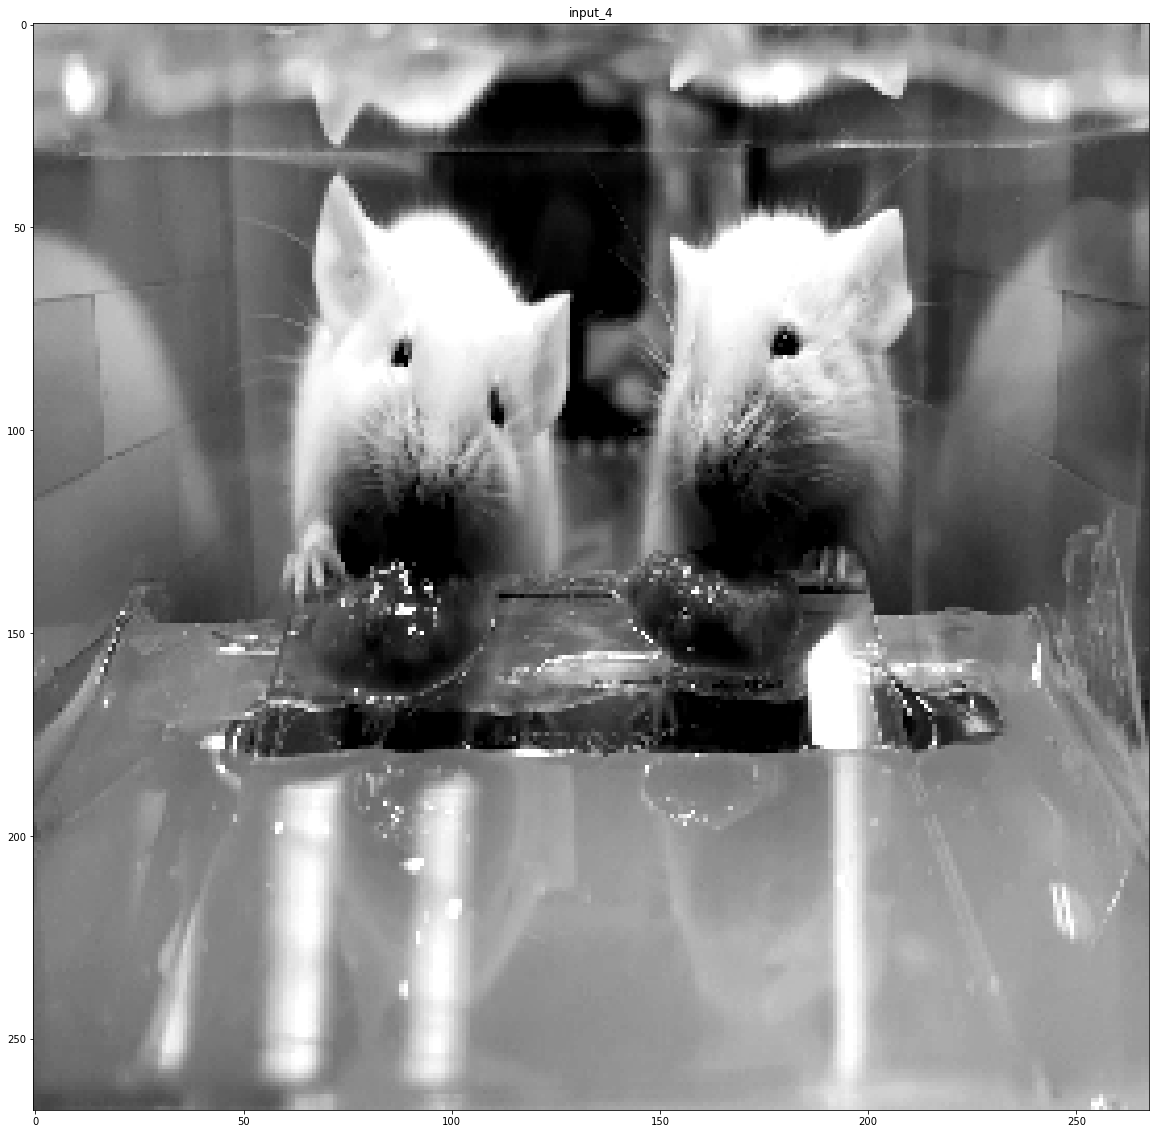

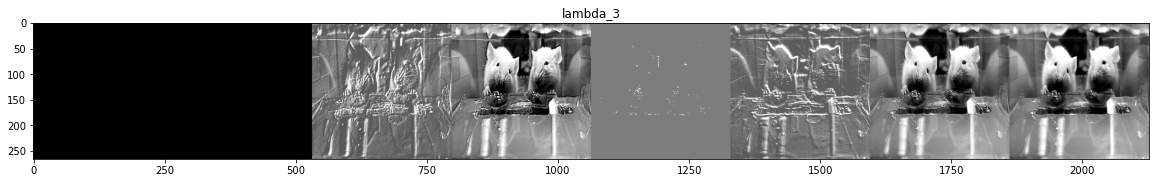

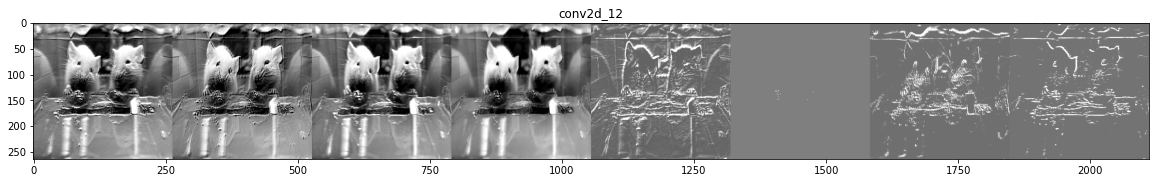

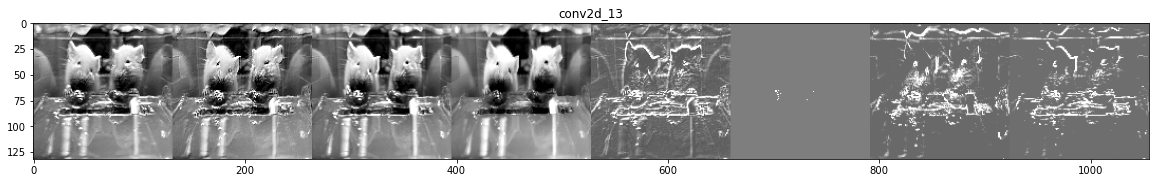

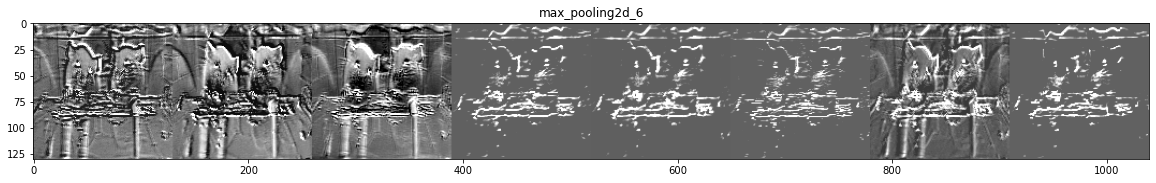

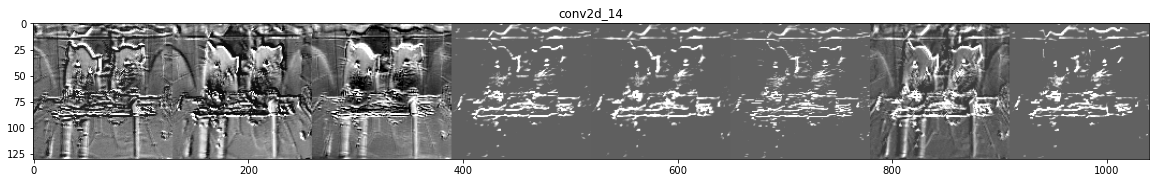

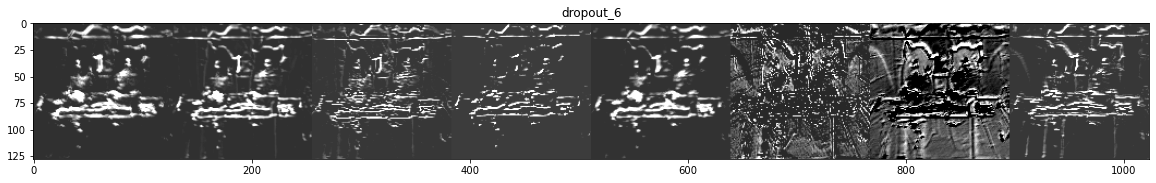

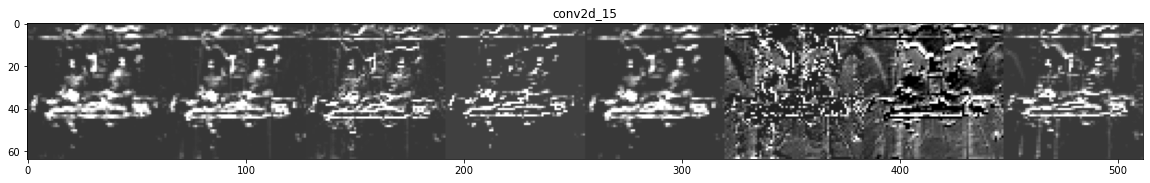

In [21]:
# generating feature map on the targeted image
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.Model(inputs = model.input, outputs = successive_outputs)

x = np_images_2D[(13199)]  # ("__indexNumber__" is changable)
#print(x)
z = []
z_row = []
z.append(x)
z=np.array(z, dtype=np.float32)

z /= 255.0

successive_feature_maps = visualization_model.predict(z)
layer_names = [layer.name for layer in model.layers]

mapsavepath = "Output_applyFlipped/"
if not os.path.exists(mapsavepath):
    os.makedirs(mapsavepath)

for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    print(feature_map.shape)
    if len(feature_map.shape) == 4:
    
    # plotting Feature maps for the conv / maxpool layers, not the fully-connected layers
        n_features = feature_map.shape[-1]  # number of features in the feature map
        size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
        # creating a matrix for image generation
        display_grid = np.zeros((size, size * n_features))
        #print(display_grid, size)

        # postprocessing the feature to be visually palatable
        for i in range(n_features):
            z  = feature_map[0, :, :, i]
            z -= z.mean()
            z /= z.std ()
            z *=  64
            z += 128
            z  = np.clip(z, 0, 255).astype('uint8')
            #print(z)
            
            # tiling each filter into a horizontal grid
            display_grid[:, i * size : (i + 1) * size] = z
            
    # displaying the grid
        scale = 20. / n_features
        plt.figure( figsize=(scale * n_features, scale) )
        plt.title ( layer_name )
        plt.grid  ( False )
        plt.imshow( display_grid, aspect='auto', cmap='gray' )
        plt.rcParams['figure.figsize'] = [10, 10]
        
    # saving
        plt.savefig(f"Output_applyFlipped/wasabiAlcoholMap_{layer_name}.jpg", dpi=300)
        

In [ ]:
# pre-defining image size for saving
from matplotlib.pyplot import figure
plt.rcParams['figure.figsize'] = [10, 10]
plt.close()
figure(figsize=(10, 10))

In [23]:
# predicting Scenario A
print("[INFO] evaluating network...")
valOBG_predictions_2Dimbalanced = model.predict(x=valOBG_feature_2Dnormalize, batch_size=BATCH_SIZE)
print(classification_report(valOBG_label_2Donehot.argmax(axis=1), 
                            valOBG_predictions_2Dimbalanced.argmax(axis=1)))


[INFO] evaluating network...
145/145 [==============================] - 62s 425ms/step
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      9254
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0

    accuracy                           0.00      9254
   macro avg       0.33      0.00      0.00      9254
weighted avg       1.00      0.00      0.00      9254



C:\Users\T1208\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\T1208\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\T1208\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
valOBG_label_2Donehot

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [25]:
valOBG_predictions_2Dimbalanced

array([[1.93800721e-28, 1.00000000e+00, 9.75004382e-29],
       [1.05628860e-27, 1.00000000e+00, 6.61105067e-26],
       [4.20679429e-26, 1.00000000e+00, 5.71271029e-25],
       ...,
       [9.49827150e-09, 3.57740610e-05, 9.99964237e-01],
       [4.41143122e-09, 1.48425715e-05, 9.99985099e-01],
       [5.78794657e-09, 3.14982499e-05, 9.99968529e-01]], dtype=float32)

In [26]:
# predicting Scenario B
print("[INFO] evaluating network...")
valOWasabi_predictions_2Dimbalanced = model.predict(x=valOWasabi_feature_2Dnormalize, batch_size=BATCH_SIZE)
print(classification_report(valOWasabi_label_2Donehot.argmax(axis=1), 
                            valOWasabi_predictions_2Dimbalanced.argmax(axis=1)))


[INFO] evaluating network...
145/145 [==============================] - 62s 424ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.71      0.83      9254
           2       0.00      0.00      0.00         0

    accuracy                           0.71      9254
   macro avg       0.33      0.24      0.28      9254
weighted avg       1.00      0.71      0.83      9254



C:\Users\T1208\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\T1208\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\T1208\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
valOWasabi_label_2Donehot

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [28]:
valOWasabi_predictions_2Dimbalanced

array([[1.93800721e-28, 1.00000000e+00, 9.75004382e-29],
       [1.05628860e-27, 1.00000000e+00, 6.61105067e-26],
       [4.20679429e-26, 1.00000000e+00, 5.71271029e-25],
       ...,
       [9.49827150e-09, 3.57740610e-05, 9.99964237e-01],
       [4.41143122e-09, 1.48425715e-05, 9.99985099e-01],
       [5.78794657e-09, 3.14982499e-05, 9.99968529e-01]], dtype=float32)

In [29]:
# predicting Scenario D
print("[INFO] evaluating network...")
valOAlcohol_predictions_2Dimbalanced = model.predict(x=valOAlcohol_feature_2Dnormalize, batch_size=BATCH_SIZE)
print(classification_report(valOAlcohol_label_2Donehot.argmax(axis=1), 
                            valOAlcohol_predictions_2Dimbalanced.argmax(axis=1)))


[INFO] evaluating network...
145/145 [==============================] - 61s 419ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       1.00      0.29      0.45      9254

    accuracy                           0.29      9254
   macro avg       0.33      0.10      0.15      9254
weighted avg       1.00      0.29      0.45      9254



C:\Users\T1208\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\T1208\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\T1208\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
valOAlcohol_label_2Donehot

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [31]:
valOAlcohol_predictions_2Dimbalanced

array([[1.93800721e-28, 1.00000000e+00, 9.75004382e-29],
       [1.05628860e-27, 1.00000000e+00, 6.61105067e-26],
       [4.20679429e-26, 1.00000000e+00, 5.71271029e-25],
       ...,
       [9.49827150e-09, 3.57740610e-05, 9.99964237e-01],
       [4.41143122e-09, 1.48425715e-05, 9.99985099e-01],
       [5.78794657e-09, 3.14982499e-05, 9.99968529e-01]], dtype=float32)

In [ ]:
# defining a function for Scenario C images prediction and previewing
def show_images_new_prediction(images, predictions, start_id, num=25):
    
    plt.gcf().set_size_inches(12,14)
    
    if num>25: num=25
    for i in range(0, num):
        ax=plt.subplot(5,5, 1+i)
        ax.imshow(images[start_id])
        if (len(predictions) > 0):
            title = "ai = " + str(valOBG_predictions_2Dimbalanced.argmax(axis=1)[start_id])
            title += "\nlabel = "
        else:
            title = "label = "
        ax.set_title(title, fontsize=12)
        ax.set_xticks([]); ax.set_yticks([])
        start_id += 370
    plt.set_cmap("Greys_r")
    plt.savefig("Output_applyFlipped\predictWasabiAlcoholSamples_2D.jpg", dpi=300)
    plt.close()

In [ ]:
# calling the defined function for saving the previewed images of Scenario C
show_images_new_prediction(np_images_2D, labels_2D, 25)

In [ ]:
del model